In [0]:
#verify our data has been successfully loaded unto the directory
dbutils.fs.ls('/FileStore/tables')

Out[1]: [FileInfo(path='dbfs:/FileStore/tables/accounts-1.zip', name='accounts-1.zip', size=5297592, modificationTime=1645611602000),
 FileInfo(path='dbfs:/FileStore/tables/accounts.zip', name='accounts.zip', size=5297592, modificationTime=1645049088000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2019.csv', name='clinicaltrial_2019.csv', size=42400056, modificationTime=1650895196000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2019_csv.gz', name='clinicaltrial_2019_csv.gz', size=10060669, modificationTime=1650836958000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2020_csv.gz', name='clinicaltrial_2020_csv.gz', size=10981608, modificationTime=1648568082000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2021/', name='clinicaltrial_2021/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2021.csv', name='clinicaltrial_2021.csv', size=50359696, modificationTime=1652375956000),
 FileInfo(path='dbfs:/FileStore/tables/cli

In [0]:
#define variables for the path fileroot and move data to local direstory
file = "clinicaltrial_2021_csv"
myfile = "clinicaltrial_2021.csv"

import os
os.environ['file'] = file
os.environ['myfile'] = myfile

dbutils.fs.cp('dbfs:/FileStore/tables/' + file + '.gz', 'file:/tmp/')

Out[2]: True

In [0]:
%sh
gunzip -d /tmp/$file.gz
mv /tmp/$file /tmp/$myfile 

In [0]:
#move unzipped data back to the directory
dbutils.fs.mv("file:/tmp/" + myfile, "dbfs:/FileStore/tables", True )

Out[4]: True

In [0]:
#confirm the previous operation was successful
dbutils.fs.ls("/FileStore/tables/clinicaltrial_2021")

Out[5]: [FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2021/clinicaltrial_2021.csv', name='clinicaltrial_2021.csv', size=50359696, modificationTime=1652103634000)]

Install Matplotlib to enable us visualize the results of the implementations.

In [0]:
%pip install matplotlib

Python interpreter will be restarted.
Python interpreter will be restarted.


TASK 1 - Count the number of distinct studies in the data

In [0]:
#read in our data into the memory
mydata = ("/FileStore/tables/clinicaltrial_2021.csv")
clinicaltrial = sc.textFile(mydata)
clinicaltrial.take(5)

Out[2]: ['Id|Sponsor|Status|Start|Completion|Type|Submission|Conditions|Interventions',
 'NCT02758028|The University of Hong Kong|Recruiting|Aug 2005|Nov 2021|Interventional|Apr 2016||',
 'NCT02751957|Duke University|Completed|Jul 2016|Jul 2020|Interventional|Apr 2016|Autistic Disorder,Autism Spectrum Disorder|',
 'NCT02758483|Universidade Federal do Rio de Janeiro|Completed|Mar 2017|Jan 2018|Interventional|Apr 2016|Diabetes Mellitus|',
 'NCT02759848|Istanbul Medeniyet University|Completed|Jan 2012|Dec 2014|Observational|May 2016|Tuberculosis,Lung Diseases,Pulmonary Disease|']

In [0]:
#count taking note the first row is the header
header = clinicaltrial.first()
clinicaltrialRDD = clinicaltrial.filter(lambda row: row !=header)
clinicaltrialRDD.count()

Out[3]: 387261

Task 2 - Generate a list of the different types of research studies present in the data in descending order of frequency.

In [0]:
#split rdd by delimiter
typeRDD = clinicaltrialRDD.map(lambda line: line.split("|"))
typeRDD.take(5)

Out[4]: [['NCT02758028',
  'The University of Hong Kong',
  'Recruiting',
  'Aug 2005',
  'Nov 2021',
  'Interventional',
  'Apr 2016',
  '',
  ''],
 ['NCT02751957',
  'Duke University',
  'Completed',
  'Jul 2016',
  'Jul 2020',
  'Interventional',
  'Apr 2016',
  'Autistic Disorder,Autism Spectrum Disorder',
  ''],
 ['NCT02758483',
  'Universidade Federal do Rio de Janeiro',
  'Completed',
  'Mar 2017',
  'Jan 2018',
  'Interventional',
  'Apr 2016',
  'Diabetes Mellitus',
  ''],
 ['NCT02759848',
  'Istanbul Medeniyet University',
  'Completed',
  'Jan 2012',
  'Dec 2014',
  'Observational',
  'May 2016',
  'Tuberculosis,Lung Diseases,Pulmonary Disease',
  ''],
 ['NCT02758860',
  'University of Roma La Sapienza',
  'Active, not recruiting',
  'Jun 2016',
  'Sep 2020',
  'Observational [Patient Registry]',
  'Apr 2016',
  'Diverticular Diseases,Diverticulum,Diverticulosis',
  '']]

In [0]:
#map types column (index 6) to create a pair rdd
typeRDD1 = typeRDD.map(lambda x: (x[5], 1))
typeRDD1.take(5)

Out[5]: [('Interventional', 1),
 ('Interventional', 1),
 ('Interventional', 1),
 ('Observational', 1),
 ('Observational [Patient Registry]', 1)]

In [0]:
#reduce by key to get count of each unique key in descending order
typeRDD2 = typeRDD1.reduceByKey(lambda x, y: x + y)
typeRDD2.takeOrdered(4, key = lambda x: -x[1])

Out[6]: [('Interventional', 301472),
 ('Observational', 77540),
 ('Observational [Patient Registry]', 8180),
 ('Expanded Access', 69)]

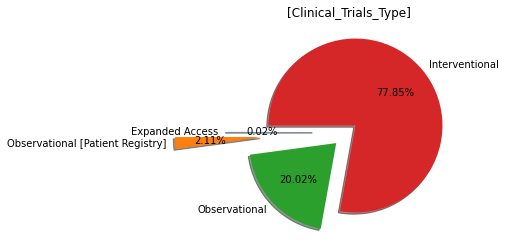

In [0]:
import matplotlib.pyplot as plt

#set plot for pie chart with research type and frequency
Frequencies = [69, 8180, 77540, 301472]
Type = ["Expanded Access", "Observational [Patient Registry]", "Observational", "Interventional"]

explode = (0.4, 1.0, 0.2, 0.1)
plt.pie(Frequencies, labels=Type, autopct='%1.2f%%', shadow=True, explode = explode, startangle = 180, radius=1)
plt.title("[Clinical_Trials_Type]", ha='center')

plt.show()

Task 3 - List of top 5 and bottom 5 conditions studied in the reserach by their frequency

In [0]:
conditionsRDD=typeRDD.flatMap(lambda x: x[7].split(","))
conditionsRDD.take(10)

Out[8]: ['',
 'Autistic Disorder',
 'Autism Spectrum Disorder',
 'Diabetes Mellitus',
 'Tuberculosis',
 'Lung Diseases',
 'Pulmonary Disease',
 'Diverticular Diseases',
 'Diverticulum',
 'Diverticulosis']

In [0]:
conditionsRDD1=conditionsRDD.filter(lambda x: x !="").map(lambda x: (x,1))
conditionsRDD1.take(10)

Out[9]: [('Autistic Disorder', 1),
 ('Autism Spectrum Disorder', 1),
 ('Diabetes Mellitus', 1),
 ('Tuberculosis', 1),
 ('Lung Diseases', 1),
 ('Pulmonary Disease', 1),
 ('Diverticular Diseases', 1),
 ('Diverticulum', 1),
 ('Diverticulosis', 1),
 ('Asthma', 1)]

In [0]:
# Top 5 conditions studied in clinical trials
conditionsRDD2=conditionsRDD1.reduceByKey(lambda x,y: (x+y))
conditionsRDD2.takeOrdered(5, key = lambda x: -x[1])

Out[10]: [('Carcinoma', 13389),
 ('Diabetes Mellitus', 11080),
 ('Neoplasms', 9371),
 ('Breast Neoplasms', 8640),
 ('Syndrome', 8032)]

In [0]:
# Bottom 5 conditions studied in clinical trials
conditionsRDD2=conditionsRDD1.reduceByKey(lambda x,y: (x+y))
conditionsRDD2.takeOrdered(5, key = lambda x: x[1])

Out[11]: [('Erythroplasia', 1),
 ('Hand-Arm Vibration Syndrome', 1),
 ('Hemobilia', 1),
 ('Alcohol Amnestic Disorder', 1),
 ('Submandibular Gland Neoplasms', 1)]

Out[12]: Text(0.5, 1.0, '[Clinical_Trial_Conditions]')

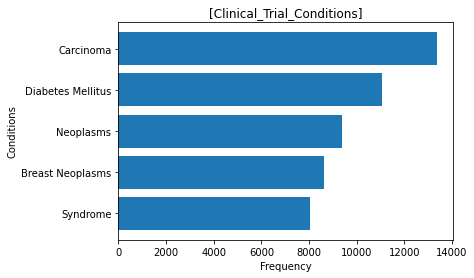

In [0]:
#set plot for horizontal bar chart with top 5 conditions studied and frequency
x = ['Syndrome', 'Breast Neoplasms', 'Neoplasms', 'Diabetes Mellitus', 'Carcinoma']
y = [8032, 8640, 9371, 11080, 13389]

plt.barh(x, y)
plt.xlabel ("Frequency")
plt.ylabel ("Conditions")
plt.title("[Clinical_Trial_Conditions]")

Task 4 - Hierarchy codes for the 5 most frequent conditions

In [0]:
myRDD = sc.textFile('dbfs:/FileStore/tables/mesh.csv')
myRDD.take(5)

Out[13]: ['term,tree',
 'Calcimycin,D03.633.100.221.173',
 'A-23187,D03.633.100.221.173',
 'Temefos,D02.705.400.625.800',
 'Temefos,D02.705.539.345.800']

In [0]:
header = myRDD.first()
meshRDD = myRDD.filter(lambda row: row !=header)
meshRDD.take(5)

Out[14]: ['Calcimycin,D03.633.100.221.173',
 'A-23187,D03.633.100.221.173',
 'Temefos,D02.705.400.625.800',
 'Temefos,D02.705.539.345.800',
 'Temefos,D02.886.300.692.800']

In [0]:
rootRDD = meshRDD.map(lambda x: x.replace("\r", ",").split(","))
rootRDD.take(5)

Out[15]: [['Calcimycin', 'D03.633.100.221.173'],
 ['A-23187', 'D03.633.100.221.173'],
 ['Temefos', 'D02.705.400.625.800'],
 ['Temefos', 'D02.705.539.345.800'],
 ['Temefos', 'D02.886.300.692.800']]

In [0]:
joinRDD = rootRDD.join(conditionsRDD2)
joinRDD.take(5)

Out[16]: [('Abdomen', ('A01.923.047', 38)),
 ('Abdominal Neoplasms', ('C04.588.033', 40)),
 ('Abetalipoproteinemia', ('C16.320.565.398.500.440.500', 2)),
 ('Abetalipoproteinemia', ('C18.452.584.500.875.440.500', 2)),
 ('Abetalipoproteinemia', ('C18.452.648.398.500.440.500', 2))]

In [0]:
joinRDD1 = joinRDD.map(lambda x: x[1]).map(lambda x: (x[0].split(".")[0], x[1]))
joinRDD1.take(5)

Out[17]: [('A01', 38), ('C04', 40), ('C16', 2), ('C18', 2), ('C18', 2)]

In [0]:
joinRDD2=joinRDD1.reduceByKey(lambda x,y: (x+y))
joinRDD2.takeOrdered(5, key = lambda x:-x[1])

Out[18]: [('C04', 143994),
 ('C23', 136079),
 ('C01', 106674),
 ('C14', 94523),
 ('C10', 92310)]

Out[19]: Text(0.5, 1.0, '[Top_5_Root_Hierarchy_Codes]')

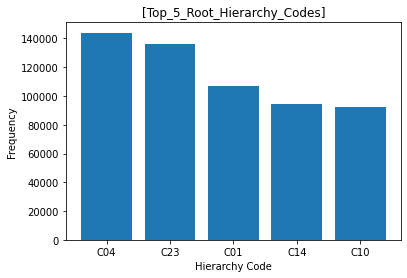

In [0]:
#set plot for horizontal bar chart with research hierarchy code and frequency
x = ['C04','C23','C01','C14','C10']
y = [143994,136079,106674,94523,92310]

plt.bar(x, y)
plt.xlabel ("Hierarchy Code")
plt.ylabel ("Frequency")
plt.title("[Top_5_Root_Hierarchy_Codes]")

Task 5 - Lis top 10 reasearch sponsors that are not pharmaceutical companies and the number of clinical trials they sponsored.

In [0]:
pharmaRDD = sc.textFile('dbfs:/FileStore/tables/pharma.csv')
pharmaRDD.take(2)

Out[20]: ['"Company","Parent_Company","Penalty_Amount","Subtraction_From_Penalty","Penalty_Amount_Adjusted_For_Eliminating_Multiple_Counting","Penalty_Year","Penalty_Date","Offense_Group","Primary_Offense","Secondary_Offense","Description","Level_of_Government","Action_Type","Agency","Civil/Criminal","Prosecution_Agreement","Court","Case_ID","Private_Litigation_Case_Title","Lawsuit_Resolution","Facility_State","City","Address","Zip","NAICS_Code","NAICS_Translation","HQ_Country_of_Parent","HQ_State_of_Parent","Ownership_Structure","Parent_Company_Stock_Ticker","Major_Industry_of_Parent","Specific_Industry_of_Parent","Info_Source","Notes"',
 '"Abbott Laboratories","Abbott Laboratories","$5,475,000","$0","$5,475,000","2013","20131227","government-contracting-related offenses","False Claims Act and related","kickbacks and bribery","Abbott Laboratories agreed to $5.475 million to resolve allegations that it violated the False Claims Act by paying kickbacks to induce doctors to implant the c

In [0]:
header = pharmaRDD.first()
pharma_RDD = pharmaRDD.filter(lambda row: row !=header).map(lambda x: x.replace('"', '').split(","))
pharma_RDD.take(5)

Out[21]: [['Abbott Laboratories',
  'Abbott Laboratories',
  '$5',
  '475',
  '000',
  '$0',
  '$5',
  '475',
  '000',
  '2013',
  '20131227',
  'government-contracting-related offenses',
  'False Claims Act and related',
  'kickbacks and bribery',
  "Abbott Laboratories agreed to $5.475 million to resolve allegations that it violated the False Claims Act by paying kickbacks to induce doctors to implant the company's carotid",
  ' biliary and peripheral vascular products.',
  'federal',
  'agency action',
  'Justice Department Civil Division',
  'civil',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  'USA',
  'Illinois',
  'publicly traded',
  'ABT',
  'pharmaceuticals',
  'pharmaceuticals',
  'https://www.justice.gov/opa/pr/abbott-laboratories-pays-us-5475-million-settle-claims-company-paid-kickbacks-physicians',
  ''],
 ['Abbott Laboratories Inc.',
  'AbbVie',
  '$1',
  '500',
  '000',
  '000',
  '$0',
  '$1',
  '500',
  '000',
  '000',
  '2012',
  '20120507',
  

In [0]:
sponsorsRDD = typeRDD.map(lambda x: (x[1],1)).reduceByKey(lambda x,y:(x+y))
sponsorsRDD.take(10)


Out[22]: [('Sponsor', 1),
 ('The University of Hong Kong', 757),
 ('Universidade Federal do Rio de Janeiro', 103),
 ('University of Roma La Sapienza', 289),
 ('Ankara University', 107),
 ('Ruijin Hospital', 200),
 ('Washington University School of Medicine', 1374),
 ('Orphazyme', 7),
 ('Novo Nordisk A/S', 1081),
 ('Bulent Ecevit University', 31)]

In [0]:
parentcoRDD = pharma_RDD.map(lambda x: (x[1],1)).reduceByKey(lambda x,y:(x+y))
parentcoRDD.take(10)

Out[23]: [('Abbott Laboratories', 26),
 ('AbbVie', 38),
 (' LLC', 26),
 ('AstraZeneca', 22),
 ('Sanofi', 24),
 ('AVEO Pharmaceuticals', 1),
 ('Bausch Health', 11),
 ('GlaxoSmithKline', 31),
 ('Teva Pharmaceutical Industries', 36),
 ('Merck', 64)]

In [0]:
# Top 10 sponsors that are not listed as Pharceutical companies
topsponsorsRDD=sponsorsRDD.subtractByKey(parentcoRDD)
topsponsorsRDD.takeOrdered(10, key=lambda x:-x[1])

Out[24]: [('National Cancer Institute (NCI)', 3218),
 ('M.D. Anderson Cancer Center', 2414),
 ('Assistance Publique - Hôpitaux de Paris', 2369),
 ('Mayo Clinic', 2300),
 ('Merck Sharp & Dohme Corp.', 2243),
 ('Assiut University', 2154),
 ('Novartis Pharmaceuticals', 2088),
 ('Massachusetts General Hospital', 1971),
 ('Cairo University', 1928),
 ('Hoffmann-La Roche', 1828)]

In [0]:
# Bottom 10 sponsors that are not listed as Pharceutical companies
topsponsorsRDD.takeOrdered(10, key=lambda x: x[1])

Out[25]: [('Sponsor', 1),
 ('James Cook University, Queensland, Australia', 1),
 ('Iron Horse Diagnostics, Inc.', 1),
 ('Sharda University', 1),
 ('Niğde State Hospital', 1),
 ('Kevin Farrell', 1),
 ('Valtari Bio', 1),
 ('Ágata Sofia da Silva Vieira', 1),
 ('Global Protection Corp.', 1),
 ('Paul Finn', 1)]

Out[26]: Text(0.5, 1.0, '[Top_10_Non_Pharma_Sponsors]')

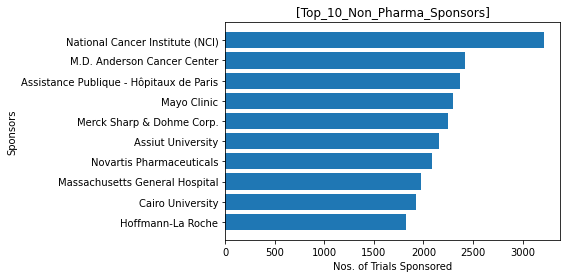

In [0]:
#set parametres for horizontal bar chart for top 10 sponsors of clinical trials that are not listed as pharmaceutical companies.
x = ['Hoffmann-La Roche','Cairo University','Massachusetts General Hospital','Novartis Pharmaceuticals','Assiut University','Merck Sharp & Dohme Corp.','Mayo Clinic','Assistance Publique - Hôpitaux de Paris','M.D. Anderson Cancer Center','National Cancer Institute (NCI)']
y = [1828, 1928, 1971, 2088, 2154, 2243, 2300, 2369, 2414, 3218]

plt.barh(x, y)
plt.xlabel ("Nos. of Trials Sponsored")
plt.ylabel ("Sponsors")
plt.title("[Top_10_Non_Pharma_Sponsors]")

Task 6 - Number of completed studies for each month in the year 2021.

In [0]:
cs_RDD = typeRDD.filter(lambda x: ("Completed" in x[2])).map(lambda x: (x[2], x[4]))
cs_RDD.take(12)

Out[27]: [('Completed', 'Jul 2020'),
 ('Completed', 'Jan 2018'),
 ('Completed', 'Dec 2014'),
 ('Completed', 'Jan 2018'),
 ('Completed', 'Jul 2017'),
 ('Completed', 'Jan 2021'),
 ('Completed', 'Oct 2016'),
 ('Completed', 'Dec 2015'),
 ('Completed', 'Mar 2016'),
 ('Completed', 'May 2019'),
 ('Completed', 'Oct 2019'),
 ('Completed', 'Apr 2015')]

In [0]:
cs_RDD1 = cs_RDD.filter(lambda x: "2021" in x[1]).map(lambda x: (x[1],1)).reduceByKey(lambda x,y:(x+y))
cs_RDD1.take(12)

Out[28]: [('Jan 2021', 1131),
 ('Jun 2021', 1094),
 ('Aug 2021', 700),
 ('Apr 2021', 967),
 ('Mar 2021', 1227),
 ('May 2021', 984),
 ('Feb 2021', 934),
 ('Jul 2021', 819),
 ('Oct 2021', 187),
 ('Sep 2021', 528)]

In [0]:
cs_RDD2=cs_RDD1.map(lambda x: (x[0].split(" ")[0], x[1]))
cs_RDD2.take(12)

Out[29]: [('Jan', 1131),
 ('Jun', 1094),
 ('Aug', 700),
 ('Apr', 967),
 ('Mar', 1227),
 ('May', 984),
 ('Feb', 934),
 ('Jul', 819),
 ('Oct', 187),
 ('Sep', 528)]

In [0]:
import calendar
m={'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10}
cs_RDD3 = cs_RDD2.sortBy(lambda x: m.get(x[0]))
cs_RDD3.collect()


Out[30]: [('Jan', 1131),
 ('Feb', 934),
 ('Mar', 1227),
 ('Apr', 967),
 ('May', 984),
 ('Jun', 1094),
 ('Jul', 819),
 ('Aug', 700),
 ('Sep', 528),
 ('Oct', 187)]

In [0]:
def remove_brackets(rdd):
    return ' '.join(str(i) for i in rdd)
cs_RDD4 = cs_RDD3.map(remove_brackets)

for i in cs_RDD4.collect():
    print(i)

Jan 1131
Feb 934
Mar 1227
Apr 967
May 984
Jun 1094
Jul 819
Aug 700
Sep 528
Oct 187


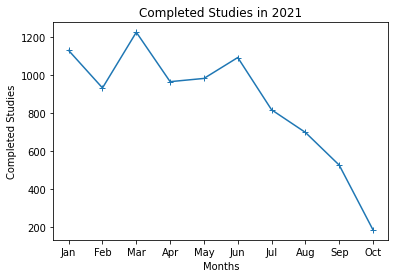

In [0]:
#create list from cs_RDD4 as input parametres 
plt.show()
x = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct']
y = [1131, 934, 1227, 967, 984, 1094, 819, 700, 528, 187]

#set plot parametres for line chart
plt.plot(x, y, marker = '+')
plt.xlabel("Months")
plt.ylabel("Completed Studies")
plt.title("Completed Studies in 2021")

plt.show()

Further Analysis 1 - Grouping the 2021 Completed studies by Type of study

In [0]:
#filter types of study with completed status
grouped_typeRDD = typeRDD.filter(lambda x: ("Completed" in x[2])).map(lambda x: (x[2], x[4], x[5]))
grouped_typeRDD.take(10)

Out[33]: [('Completed', 'Jul 2020', 'Interventional'),
 ('Completed', 'Jan 2018', 'Interventional'),
 ('Completed', 'Dec 2014', 'Observational'),
 ('Completed', 'Jan 2018', 'Interventional'),
 ('Completed', 'Jul 2017', 'Interventional'),
 ('Completed', 'Jan 2021', 'Interventional'),
 ('Completed', 'Oct 2016', 'Observational'),
 ('Completed', 'Dec 2015', 'Observational'),
 ('Completed', 'Mar 2016', 'Observational'),
 ('Completed', 'May 2019', 'Interventional')]

In [0]:
# get types completed in 2021 only
grouped_typeRDD2 = grouped_typeRDD.filter(lambda x: ("2021" in x[1])).map(lambda x: (x[1], x[2]))
grouped_typeRDD2.take(10)

Out[34]: [('Jan 2021', 'Interventional'),
 ('Jun 2021', 'Interventional'),
 ('Mar 2021', 'Interventional'),
 ('Jan 2021', 'Interventional'),
 ('May 2021', 'Interventional'),
 ('Feb 2021', 'Interventional'),
 ('Feb 2021', 'Interventional'),
 ('May 2021', 'Interventional'),
 ('Aug 2021', 'Interventional'),
 ('May 2021', 'Interventional')]

In [0]:
#reduce by key to obtain types of studies completed in 2021
grouped_typeRDD3 = grouped_typeRDD2.map(lambda x: (x[1],1)).reduceByKey(lambda x,y:(x+y))
grouped_typeRDD3.collect()

Out[35]: [('Observational', 1891),
 ('Observational [Patient Registry]', 247),
 ('Interventional', 6433)]